# HeadHunt

We're going to teach a program what kinds of jobs we like, using labeled Gmail messages as a training source.

Suggested fields:
timestamp type source raw text label

# Where was I?

To recap, we have:

* Downloaded _all_ of our emails, w/ their labels included
* Extracted their underlying text, for use as a Bag of Words
* Classified good job offers from bad job offers

Now, our challenge is to:

* Classify what whether something _is_ a job offer
* If it is, run it through the job-offer classifier to decide whether it's a good or bad offer.

To accomplish the first, we simply need an boolean index into our 
dataset that says whether something is a job-offer (True) or 
not (False). The challenge is our labels live as a list inside the downloaded Gmail Message resource, and we'd need to perform a boolean `contains` operation on each message. We could formalize our problem as:

    ???
    
The second is a bit easier to solve. We have a tree of labels, starting with a root of no label at all. Each non-leaf node of the tree will have an associated classifier, which assigns likelihoods to each of its children. We then simply have to run `predict` at each level of the tree, and follow the most likely path(s).

In [39]:
%matplotlib inline
import pickle 
import sys

MATCHWELL = '../matchwell'
if MATCHWELL not in sys.path:
    sys.path.insert(0, MATCHWELL)

import pandas as pd
%load_ext autoreload
%autoreload 2
from matchwell import models, gmail, measure, util
from importlib import reload


# Constants
POS_LABEL = 'job-offers/yes'
NEG_LABEL = 'job-offers/no'
DATAFILE = './matchwell.h5'
CLASSIFIER = './text_pipeline.pkl'

# Load DataFrame; 'all' or 'emails' are the choices
# all: The full set of downloaded emails & text messages
# emails: A pre-processed set of emails for training
df = pd.read_hdf(DATAFILE, 'emails') 

# Load classifier
clf = models.load_model(CLASSIFIER)

gml = gmail.Gmail().connect()

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [23]:
reload(gmail)
gml = gmail.Gmail().connect()

In [186]:
# Checkpoint!
df.to_hdf(DATAFILE, 'emails')

/opt/conda/lib/python3.5/site-packages/pandas/core/generic.py:1101: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed,key->block0_values] [items->['id', 'raw', 'threadId', 'text', 'labels']]

  return pytables.to_hdf(path_or_buf, key, self, **kwargs)


In [15]:
job_offer_idx = df.apply(lambda x: util.contains_substring('job-offers', x['labels']), axis=1)
job_offer_idx.sum()

175

In [7]:
from sklearn.linear_model import SGDClassifier
from matchwell import models

clf = SGDClassifier(loss='hinge', penalty='l2', alpha=1e-3,
                    n_iter=50, random_state=42)
pl = models.build_pipeline(clf, df['text'], job_offer_idx)

In [8]:
X = df['text']
y = job_offer_idx
pred = pl.predict(X)

In [9]:
# measure.cv_scores(pl, df['text'], job_offer_idx, plot=True)
from sklearn.metrics import classification_report, accuracy_score
measure.report(pred, y, labels=['Negative', 'Job Offer'])

0.99% accuracy on the training set
Classification Report
              precision    recall  f1-score   support

   Negative       1.00      0.99      1.00     13905
  Job Offer       0.26      1.00      0.41        45

avg / total       1.00      0.99      0.99     13950

Confusion Matrix
 [[13775   130]
 [    0    45]]


In [10]:
from sklearn.cross_validation import cross_val_score
scores = cross_val_score(pl, X, y, cv=5)

In [11]:
scores

array([ 0.98602151,  0.98888889,  0.98888889,  0.99032258,  0.98960573])

In [13]:
pl.predict(df['text'].sample())

array([False], dtype=bool)

In [19]:
import networkx as nx
DG = nx.DiGraph()

{'': <matplotlib.text.Text at 0x7fb64bd59710>,
 '10th': <matplotlib.text.Text at 0x7fb64a401588>,
 'AT': <matplotlib.text.Text at 0x7fb64a43db00>,
 'ATG': <matplotlib.text.Text at 0x7fb64a45a5c0>,
 'Apt': <matplotlib.text.Text at 0x7fb64a466080>,
 'BMCB 755': <matplotlib.text.Text at 0x7fb64a4eab00>,
 'Banking': <matplotlib.text.Text at 0x7fb64a455080>,
 'Bills & Payments': <matplotlib.text.Text at 0x7fb64a414048>,
 'CATEGORY_FORUMS': <matplotlib.text.Text at 0x7fb64a4f4d68>,
 'CATEGORY_PERSONAL': <matplotlib.text.Text at 0x7fb64a414588>,
 'CATEGORY_PROMOTIONS': <matplotlib.text.Text at 0x7fb64a40d588>,
 'CATEGORY_SOCIAL': <matplotlib.text.Text at 0x7fb64a407588>,
 'CATEGORY_UPDATES': <matplotlib.text.Text at 0x7fb64a40dac8>,
 'CHAT': <matplotlib.text.Text at 0x7fb64a45a080>,
 'CI': <matplotlib.text.Text at 0x7fb64a4f6f98>,
 'CS 595': <matplotlib.text.Text at 0x7fb64a455b00>,
 'CS 712': <matplotlib.text.Text at 0x7fb64a49fb38>,
 'CS 760W': <matplotlib.text.Text at 0x7fb64a40d048>,
 'CS

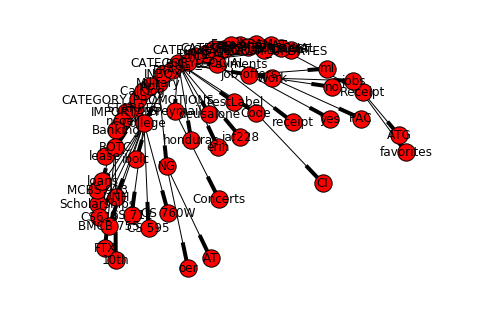

In [46]:
lt = gml.label_tree
edges = util.ancestral_walk(lt)
DG.add_edges_from(edges)
spring = nx.spring_layout(DG, k=.1)
nx.draw(DG, pos=spring)
nx.draw_networkx_labels(DG, pos=spring)